### From playing around with dPCA, figured we could do Anova on single units, certain conditions. 

- Formalize some code from here: /src/wcst_decode/notebooks/20250325_revisit_dpca.ipynb, revamp so it works with generic conditions, not trial-averaged activity
- Conditions here are: Response (Correct/Incorrect), Features (Chose feat/ not)

In [3]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import SESS_SPIKES_PATH, TrialInterval, UNITS_PATH
import seaborn as sns
from scripts.pseudo_decoding.single_selected_feature_configs import *
import scipy
import argparse
import copy
import itertools
from tqdm import tqdm
from tqdm.auto import tqdm  # for notebooks
from utils.anova_utils import anova_session, load_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
FEATS_PATH = "/data/patrick_res/sessions/SA/feats_at_least_3blocks.pickle"
SESSIONS_PATH = "/data/patrick_res/sessions/SA/valid_sessions.pickle"
# feat = "STAR"
feat_sessions = pd.read_pickle(FEATS_PATH)
valid_sess = pd.read_pickle(SESSIONS_PATH)
# row = feat_sessions[feat_sessions.feat == feat].iloc[0]
# sessions = valid_sess[valid_sess.session_name.isin(row.sessions)]
interval = TrialInterval("FeedbackOnset", 1800, 1500, 100)



In [6]:
tqdm.pandas()
all_res = []
for feat in tqdm(FEATURES):
    row = feat_sessions[feat_sessions.feat == feat].iloc[0]
    sessions = valid_sess[valid_sess.session_name.isin(row.sessions)]
    res = pd.concat(sessions.progress_apply(lambda x: anova_session(x, feat, ["Response", "Choice", "TimeBins"], interval), axis=1).values)
    res["interaction_frac"] = res.x_ResponseChoice_fracvar + res.x_ResponseChoiceTimeBins_fracvar
    res["feat"] = feat
    all_res.append(res)
all_res = pd.concat(all_res)


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var


  0%|          | 0/21 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var


  0%|          | 0/25 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [8]:
units = all_res.sort_values(by="interaction_frac", ascending=False)[:10]

In [ ]:
units

,PseudoUnitID,total_var,x_Response_fracvar,x_Choice_fracvar,x_TimeBins_fracvar,x_ResponseChoice_fracvar,x_ResponseTimeBins_fracvar,x_ChoiceTimeBins_fracvar,x_ResponseChoiceTimeBins_fracvar,residual_fracvar,sum_fracvar,interaction_frac,feat
12,2018082212,12.513838,0.090327,0.020611,0.107340,0.011906,0.020602,0.002981,0.005147,0.734657,0.993570,0.017053,CIRCLE
12,2018090712,185.821330,0.014487,0.008881,0.017568,0.015760,0.007201,0.000806,0.000899,0.936934,1.002536,0.016659,SQUARE
14,2018092814,529.887700,0.256616,0.007229,0.032316,0.007369,0.008557,0.007700,0.008611,0.701657,1.030054,0.015980,SQUARE
30,2018080330,19.466458,0.032981,0.021128,0.046034,0.009981,0.028904,0.009070,0.005884,0.843742,0.997725,0.015865,TRIANGLE
14,2018100414,132.548990,0.292062,0.010901,0.028845,0.005568,0.008194,0.006470,0.008318,0.667464,1.027822,0.013886,POLKADOT
14,2018100414,132.548990,0.292062,0.002836,0.028845,0.006726,0.008040,0.007484,0.007110,0.666713,1.019817,0.013836,MAGENTA
20,2018091920,4.857441,0.000075,0.000765,0.011981,0.009347,0.028587,0.005848,0.003737,0.938371,0.998711,0.013084,STAR
15,2018080615,31.543115,0.025497,0.020322,0.071389,0.008928,0.013165,0.005431,0.003489,0.848167,0.996388,0.012417,TRIANGLE
30,2018080330,19.466458,0.032981,0.017419,0.046034,0.005542,0.028890,0.007140,0.006334,0.856454,1.000794,0.011876,STAR
14,2018090414,10.658976,0.157840,0.000661,0.053637,0.006579,0.006878,0.004122,0.005092,0.775325,1.010134,0.011671,GREEN


In [ ]:
units.PseudoUnitID.values

array([2018082212, 2018090712, 2018092814, 2018080330, 2018100414,
       2018100414, 2018091920, 2018080615, 2018080330, 2018090414])

In [11]:
unit_pos = pd.read_pickle(UNITS_PATH.format(sub="SA"))


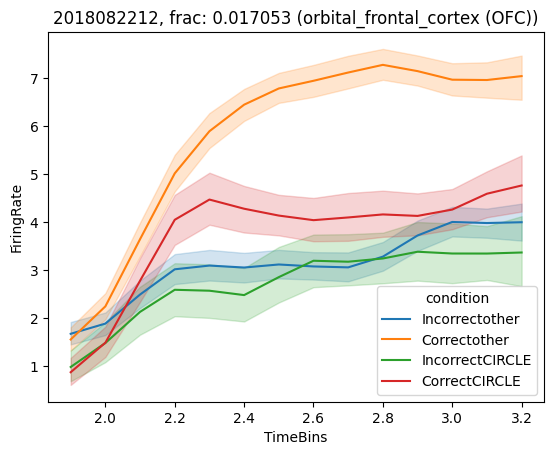

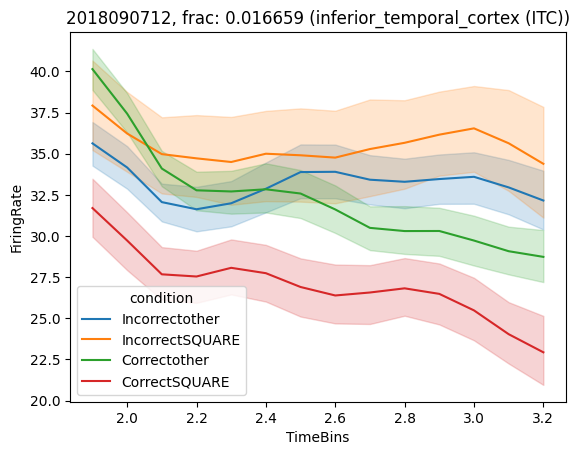

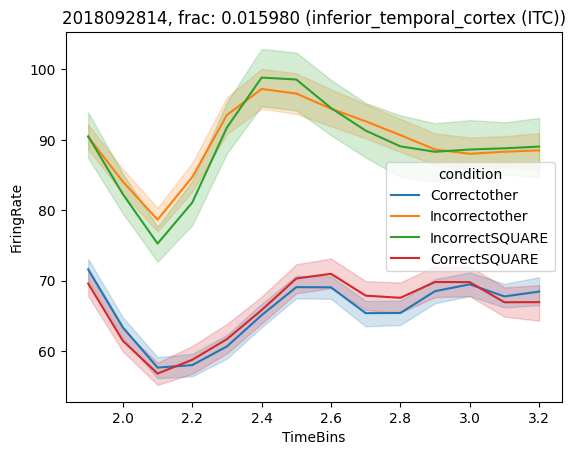

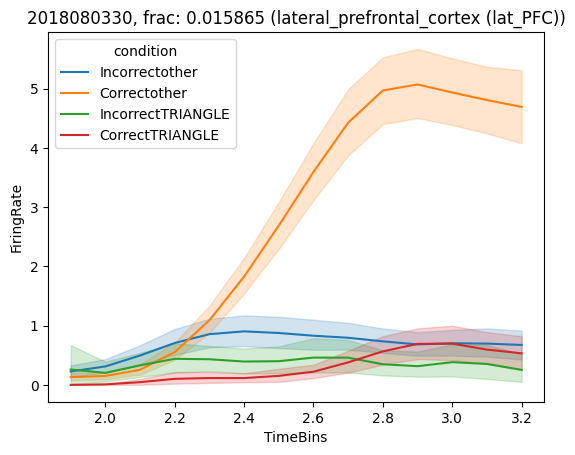

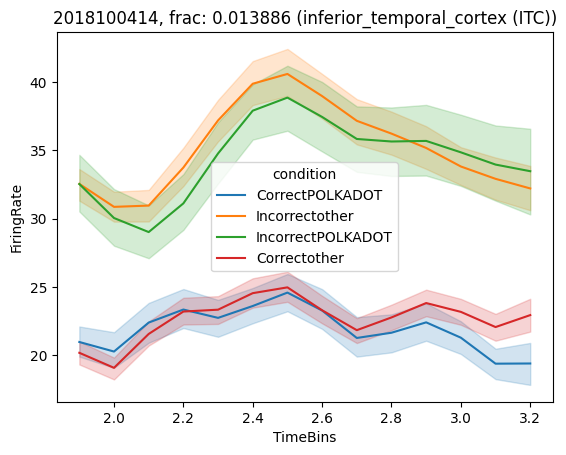

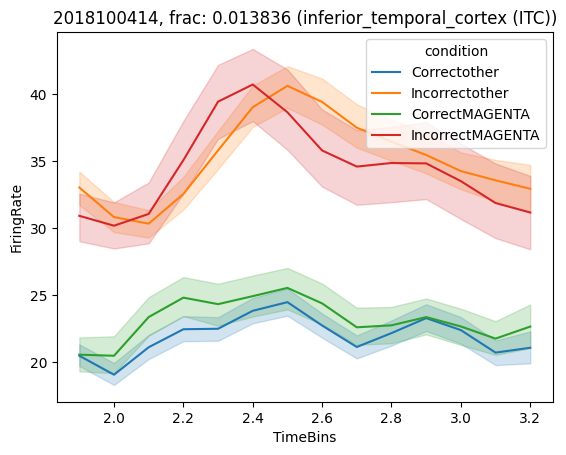

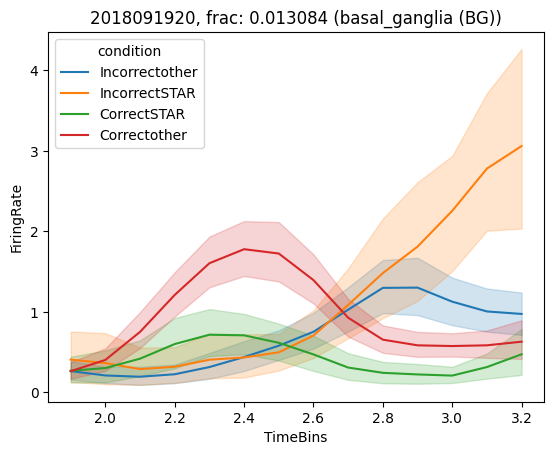

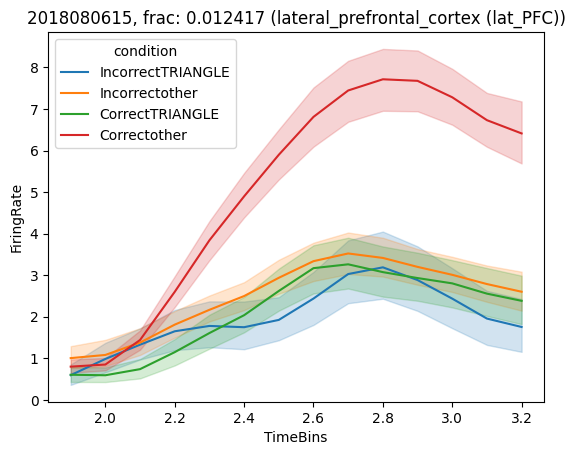

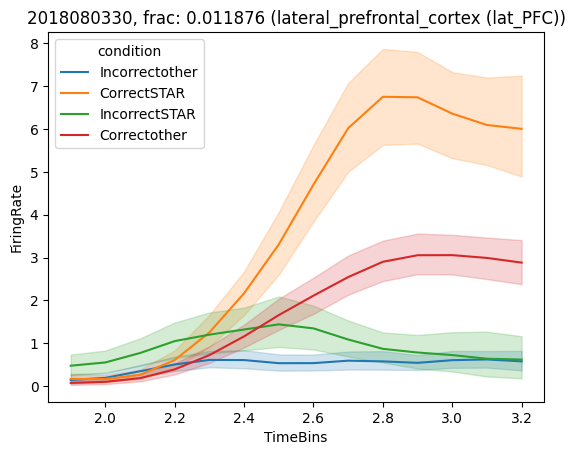

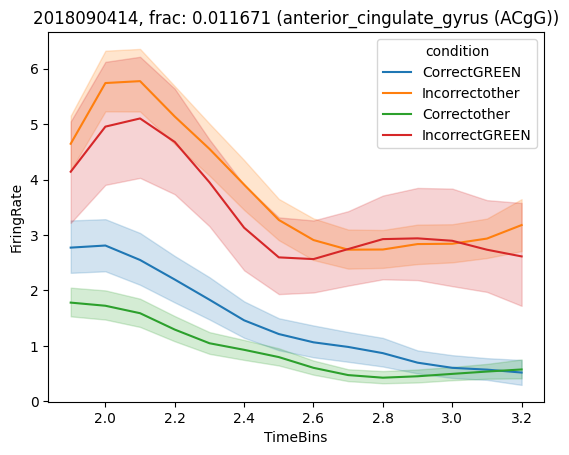

In [12]:
for i, unit in units.iterrows():
    unit_id = unit.PseudoUnitID
    unit_frs = load_data(int(unit_id / 100), unit.feat, interval, unit_id=unit_id)
    # unit_frs["FeatPreferred"] = unit_frs["PreferredBelief"].apply(lambda x: x == feat)
    unit_frs["condition"] = unit_frs["Response"] + unit_frs["Choice"] 
    pos = unit_pos[unit_pos.PseudoUnitID == unit_id].iloc[0].structure_level2

    fig, ax = plt.subplots()
    sns.lineplot(unit_frs, x="TimeBins", y="FiringRate", hue="condition", ax=ax)
    ax.set_title(f"{unit_id}, frac: {unit.interaction_frac:3f} ({pos})")